

The set-up
==========
* The data points are uniformly distributed in [0,100]
* The feature-effect is made from 10 piece-wise linear parts of length 10;

For different values of parameters:
* N: nof points
* noise_level: how much noise to add in the data_effect estimation

Questions to be addressed
=========================
For fixed-size bins:
* what is the best K in terms of accuracy?
* Does standard mse_fixed_size or variance estimator chooses the best K?
For variable-sized bins:
* what is the best (a) number and (b) size of bins, in terms of mse_fixed_size?
* does dynamic programming based on mse_fixed_size finds them and for which K?
* does dynamic programming based on standard mse_fixed_size finds them and for which K?

Final Goals
===========
* show that choosing the correct bin-size K is crucial
* in cases of uniformly distributed data, choosing a big K is always a good option - or even the best option
 (independently of noise level and nof points)
* show that variable-size bins, has equivalent accuracy with fixed-bin in case of fixed-size piecewise linear effect
 and our algorithm is able to find variable-sizes with equivalent accuracy in this case
* show that standard mse_fixed_size is a good estimator of the best bin size

Experiments
===========

(a) For noise_level = 0
=======================
For fixed-size bins:
* The best K are the ones that permit changing bin every 10
i.e. K = {10, 20, 30, ..., 100} or dx = {10, 10/2=5 ,10/3=3.33, ... , 10/10=1}
* but in the range of big K, all choices have good accuracy
* Standard mse_fixed_size perfectly chooses the best candidates
For Variable-size bins:
* Finds good bins based on accuracy
* Finds good bins base on standard mse_fixed_size


The conclusions above, hold independently of the number of points. In case of limited points, variable-size bins can be
"wrong" but this is due to the absence of points, not a problem of the method.


(b) For noise_level = 3.0
=======================
For fixed-size bins:
* The best K are the ones that permit changing bin every 10
i.e. K = {10, 20, 30, ..., 100} or dx = {10, 10/2=5 ,10/3=3.33, ... , 10/10=1}
* but in the range of big K, all choices have good accuracy
* Standard mse_fixed_size perfectly chooses the best candidates
For Variable-size bins:
* Finds good bins based on accuracy
* Finds good bins base on standard mse_fixed_size


In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import matplotlib.pyplot as plt
import ipywidgets as widgets
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
import numpy as np
import examples.example_utils as utils
import feature_effect as fe

In [4]:
def f_params():
    def find_a(params, x_start):
        params[0]["a"] = x_start
        for i, param in enumerate(params):
            if i < len(params) - 1:
                a_next = param["a"] + (param["to"] - param["from"]) * param["b"]
                params[i + 1]["a"] = a_next

    params = [{"b":0.3, "from": 0., "to": 10.},
              {"b":7., "from": 10, "to": 20},
              {"b":-1.5, "from": 20, "to": 30},
              {"b":0., "from": 30, "to": 40},
              {"b":-5., "from": 40, "to": 50},
              {"b":0.3, "from": 50, "to": 60},
              {"b":7., "from": 60, "to": 70},
              {"b":-1.5, "from": 70, "to": 80},
              {"b":0., "from": 80, "to": 90},
              {"b":-5., "from": 90, "to": 100}]
    x_start = -1
    find_a(params, x_start)
    return params


def generate_samples(N):
    eps = 1e-05
    x = np.random.uniform(0, 100-eps, size=int(N))
    x = np.expand_dims(np.concatenate((np.array([0.0]), x, np.array([100. - eps]))), axis=-1)
    return x


In [10]:
N = 100
noise_level = 1
K_max_fixed = 50
K_max_varcontains = 40
min_points_per_bin = 10

In [11]:
# init functions
seed = 4834545
np.random.seed(seed)

model = utils.create_f1_center(f_params)
model_jac = utils.create_data_effect(f_params, noise_level, seed)
data = generate_samples(N=N)
y = model(data)
data_effect = model_jac(data)

# DALE fixed-size interactive

In [12]:
dale = fe.DALE(data=data, model=model, model_jac=model_jac)
def plot(bins):
    dale.fit(features=[0], alg_params={"nof_bins": bins})
    dale.plot(s=0, block=False, gt=model)
    plt.show()

dale_plot = widgets.interactive(plot, bins=(1, 100, 1))
dale_output = dale_plot.children[-1]
dale_output.layout.height = '400px'
dale_plot

interactive(children=(IntSlider(value=50, description='bins', min=1), Output(layout=Layout(height='400px'))), …

# DALE variable-size interactive

In [13]:
dale = fe.DALE(data=data, model=model, model_jac=model_jac)
gt_bins = utils.create_gt_bins(f_params)
def plot(bins):
    dale.fit(features=[0], alg_params={"max_nof_bins": bins}, method = "variable-size")
    # dale.plot(s=0, block=False, gt=model)
    
    lims = dale.dale_params["feature_0"]["limits"]
    positions = [(lims[i] + (lims[i+1] - lims[i])/2) for i in range(len(lims) - 1)]
    dx = [lims[i+1]-lims[i] for i in range(len(lims) - 1)]
    height = dale.dale_params["feature_0"]["bin_effect"]
    plt.bar(x=positions, height=height, width=dx, color=(0.1, 0.1, 0.1, 0.1), edgecolor='blue', label="bin estimation")

    
    lims = gt_bins["limits"]
    positions = [(lims[i] + (lims[i+1] - lims[i])/2) for i in range(len(lims) - 1)]
    height = gt_bins["height"]
    dx = [lims[i+1]-lims[i] for i in range(len(lims) - 1)]
    plt.bar(x=positions, height=height, width=dx, color=(0.1, 0.1, 0.1, 0.1), edgecolor='red', label="bin gt")
    
    plt.legend()
    plt.show()

dale_plot = widgets.interactive(plot, bins=(1, 66, 1))
dale_output = dale_plot.children[-1]
dale_output.layout.height = '400px'
dale_plot

interactive(children=(IntSlider(value=33, description='bins', max=66, min=1), Output(layout=Layout(height='400…

In [14]:
k_list_fixed, mse_fixed, loss_fixed, dale_fixed = utils.count_loss_mse(K_max_fixed, model, data, model, model_jac,
                                                                       min_points_per_bin, method="fixed-size")
k_list_var, mse_var, loss_var, dale_var = utils.count_loss_mse(K_max_var, model, data, model, model_jac,
                                                               min_points_per_bin, method="variable-size")

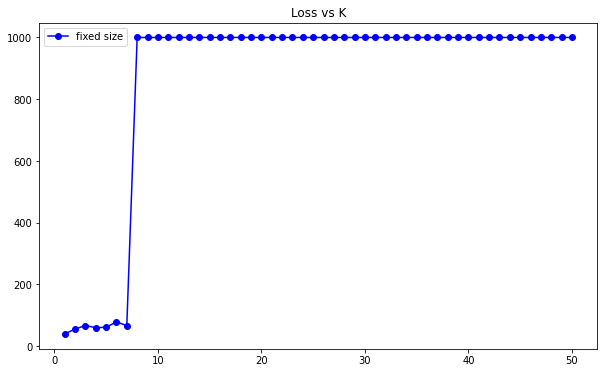

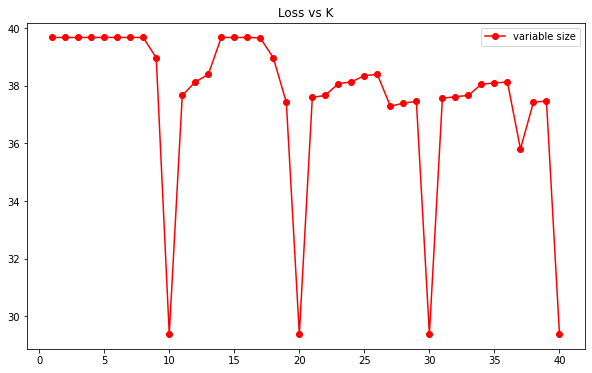

In [15]:
# plot
plt.figure()
plt.title("Loss vs K")
plt.plot(k_list_fixed, loss_fixed, "bo-", label="fixed size")
plt.legend()
plt.show(block=False)

plt.figure()
plt.title("Loss vs K")
plt.plot(k_list_var, loss_var, "ro-", label="variable size")
plt.legend()
plt.show(block=False)


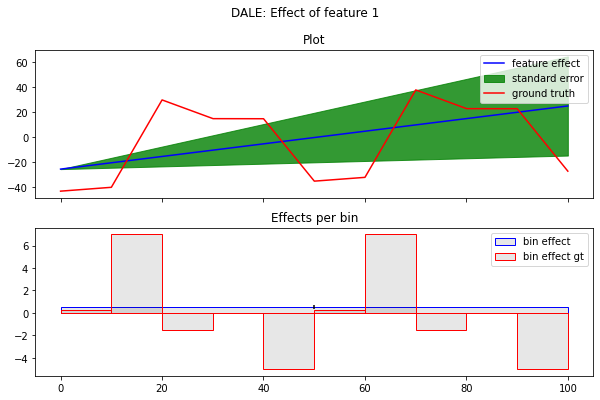

In [16]:
# plot best fixed solution
best_fixed = np.nanargmin(loss_fixed)
dale_fixed[best_fixed].plot(s=0,
                            gt=model,
                            gt_bins=utils.create_gt_bins(f_params),
                            block=False)


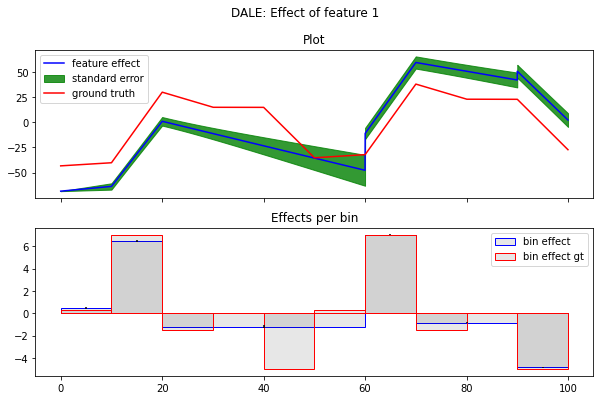

In [17]:
# plot best variable size solution
best_var = np.nanargmin(loss_var)
dale_var[best_var].plot(s=0,
                        gt=model,
                        gt_bins=utils.create_gt_bins(f_params),
                        block=False)


# DALE fixed-size: best solution based on auto algorithm

In [18]:
best_fixed = np.nanargmin(loss_fixed)
print("===========================================")
print("Best K is: %2d, with loss=%.3f" % (best_fixed+1, loss_fixed[best_fixed]))

print("===========================================")
print("Dx is: %.3f" %(dale_fixed[best_fixed].dale_params["feature_0"]["dx"]))

print("===========================================")
print("Effect per bin is:")
print(dale_fixed[best_fixed].dale_params["feature_0"]["bin_effect"])

print("===========================================")
print("Loss per K:")
for i, k in enumerate(k_list_fixed):
    print("Fixed-size k= %d, loss=%.3f" % (k, loss_fixed[i]))

Best K is:  1, with loss=39.671
Dx is: 100.000
Effect per bin is:
[0.50508179]
Loss per K:
Fixed-size k= 1, loss=39.671
Fixed-size k= 2, loss=55.658
Fixed-size k= 3, loss=66.866
Fixed-size k= 4, loss=60.208
Fixed-size k= 5, loss=61.244
Fixed-size k= 6, loss=78.948
Fixed-size k= 7, loss=66.608
Fixed-size k= 8, loss=1000.000
Fixed-size k= 9, loss=1000.000
Fixed-size k= 10, loss=1000.000
Fixed-size k= 11, loss=1000.000
Fixed-size k= 12, loss=1000.000
Fixed-size k= 13, loss=1000.000
Fixed-size k= 14, loss=1000.000
Fixed-size k= 15, loss=1000.000
Fixed-size k= 16, loss=1000.000
Fixed-size k= 17, loss=1000.000
Fixed-size k= 18, loss=1000.000
Fixed-size k= 19, loss=1000.000
Fixed-size k= 20, loss=1000.000
Fixed-size k= 21, loss=1000.000
Fixed-size k= 22, loss=1000.000
Fixed-size k= 23, loss=1000.000
Fixed-size k= 24, loss=1000.000
Fixed-size k= 25, loss=1000.000
Fixed-size k= 26, loss=1000.000
Fixed-size k= 27, loss=1000.000
Fixed-size k= 28, loss=1000.000
Fixed-size k= 29, loss=1000.000
Fixe

# DALE variable-size: best solution based on auto algorithm

In [19]:
best_var = np.nanargmin(loss_var)
print("===========================================")
print("Best K is: %2d, with loss=%.3f" % (best_var+1, loss_var[best_var]))

print("===========================================")
print("Bin limits are:")
print(dale_var[best_var].dale_params["feature_0"]["limits"])

print("===========================================")
print("Effect per bin is:")
print(dale_var[best_var].dale_params["feature_0"]["bin_effect"])

print("===========================================")
print("Loss per K:")
for i, k in enumerate(k_list_var):
    print("Fixed-size k= %d, loss=%.3f" % (k, loss_var[i]))

Best K is: 10, with loss=29.391
Bin limits are:
[ 0.          9.999999   19.999998   59.999994   69.999993   89.999991
 99.99999002]
Effect per bin is:
[ 0.46451562  6.45363526 -1.21304643  7.03811603 -0.86711298 -4.82962525]
Loss per K:
Fixed-size k= 1, loss=39.671
Fixed-size k= 2, loss=39.671
Fixed-size k= 3, loss=39.671
Fixed-size k= 4, loss=39.671
Fixed-size k= 5, loss=39.671
Fixed-size k= 6, loss=39.671
Fixed-size k= 7, loss=39.671
Fixed-size k= 8, loss=39.671
Fixed-size k= 9, loss=38.965
Fixed-size k= 10, loss=29.391
Fixed-size k= 11, loss=37.663
Fixed-size k= 12, loss=38.128
Fixed-size k= 13, loss=38.390
Fixed-size k= 14, loss=39.671
Fixed-size k= 15, loss=39.671
Fixed-size k= 16, loss=39.671
Fixed-size k= 17, loss=39.656
Fixed-size k= 18, loss=38.965
Fixed-size k= 19, loss=37.425
Fixed-size k= 20, loss=29.391
Fixed-size k= 21, loss=37.591
Fixed-size k= 22, loss=37.663
Fixed-size k= 23, loss=38.072
Fixed-size k= 24, loss=38.128
Fixed-size k= 25, loss=38.348
Fixed-size k= 26, los